# Preparation

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
a = torch.tensor(2.0, requires_grad=True)
b = 2 * a

db = torch.tensor(0.5)
da = 2.0 * db
b.backward(gradient=db)
print(da)
print(a.grad)

tensor(1.)
tensor(1.)


In [3]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
alphabet = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(alphabet)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

# Data

In [5]:
import typing as tp


def build_dataset(words: tp.List):
    X, Y = [], []
    for w in words:
        window = [0] * 3
        for ch in w + ".":
            ix = stoi[ch]
            X.append(window)
            Y.append(ix)
            window = window[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)

train_size = int(0.8 * len(words))
validation_size = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:train_size])
Xval, Yval = build_dataset(words[train_size:validation_size])
Xtest, Ytest = build_dataset(words[validation_size:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Manual Gradients

In [6]:
import torch


def cmp(s: str, derivative: torch.Tensor, tensor: torch.Tensor) -> None:
    ex = torch.all(derivative == tensor.grad).item()
    app = torch.allclose(derivative, tensor.grad)
    maxdiff = (derivative - tensor.grad).abs().max().item()
    print(f"{s:5s} | Exact: {str(ex):5s} | Approximate: {str(app):5s} | MaxDiff: {str(maxdiff):5s}")

In [7]:
cmp("test", da, a)

test  | Exact: True  | Approximate: True  | MaxDiff: 0.0  


In [8]:
# Constants
ALPHABET_SPACE = len(stoi)
NGRAM_SIZE = 3
REPRESENTATION_DIM = 10
HIDDEN_LAYER_DIM = 64
MINI_BATCH_SIZE = 32

In [9]:
# Model
import torch

g = torch.Generator().manual_seed(2147483647)
C = torch.randn([ALPHABET_SPACE, REPRESENTATION_DIM], generator=g)  # (27, 10)
# Layer 1
W1 = (
    torch.randn([NGRAM_SIZE * REPRESENTATION_DIM, HIDDEN_LAYER_DIM], generator=g)
    * (5 / 3)
    / ((NGRAM_SIZE * REPRESENTATION_DIM) ** 0.5)  # Kaiming's Init
)  # (30, 64)
b1 = torch.randn([HIDDEN_LAYER_DIM], generator=g) * 0.1  # (64,)
# Layer 2
W2 = torch.randn([HIDDEN_LAYER_DIM, ALPHABET_SPACE], generator=g) * 0.1  # (64, 27)
b2 = torch.randn([ALPHABET_SPACE], generator=g) * 0.1  # (27,)
# BatchNorm Layer
bngain = torch.randn([1, HIDDEN_LAYER_DIM]) * 0.1 + 1.0  # (64,)
bnbias = torch.randn([1, HIDDEN_LAYER_DIM]) * 0.1  # (64,)

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [10]:
# One mini batch
ix = torch.randint(0, Xtr.shape[0], (MINI_BATCH_SIZE,), generator=g)

Xb, Yb = Xtr[ix], Ytr[ix]

In [11]:
# Feed Forward Once
"""
emb = C[Xb]
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yb)
"""
emb = C[Xb]
emb_concat = emb.view(emb.shape[0], -1)
# Linear Layer 1
linear = emb_concat @ W1 + b1
# Batch Norm
bn_mean = (1 / MINI_BATCH_SIZE) * linear.sum(dim=0, keepdim=True)
bn_diff = linear - bn_mean
bn_diff_square = bn_diff**2
bn_var = (1 / (MINI_BATCH_SIZE - 1)) * bn_diff_square.sum(dim=0, keepdim=True)
bn_var_inv = (bn_var + 1e-5) ** -0.5
bn_raw = bn_diff * bn_var_inv
bn_scaled = bngain * bn_raw + bnbias
# Activation
hidden = torch.tanh(bn_scaled)
# Linear Layer 2
logits = hidden @ W2 + b2
# Cross Entropy
logits_max = logits.max(
    1, keepdim=True
).values  # For numerical stability. Softmax(x_i) = (exp(x_i - max(x_i)) / sum(exp(x_i - max(x_i))))
logits_norm = logits - logits_max
counts = logits_norm.exp()
counts_sum = counts.sum(dim=1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(MINI_BATCH_SIZE), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [
    logprobs,
    probs,
    counts_sum_inv,
    counts_sum,
    counts,
    logits_norm,
    logits_max,
    logits,
    hidden,
    bn_scaled,
    bn_raw,
    bn_var_inv,
    bn_var,
    bn_diff_square,
    bn_diff,
    bn_mean,
    linear,
    emb_concat,
    emb,
]:
    t.retain_grad()

loss.backward()
loss

tensor(3.3499, grad_fn=<NegBackward0>)

In [67]:
# Backward Pass
import torch.nn.functional as F

# ======== Cross Entropy ========
# loss = -logprobs[range(MINI_BATCH_SIZE), Yb].mean()
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(logprobs.shape[0]), Yb] = -1.0 / logprobs.shape[0]
cmp("dlogprobs", dlogprobs, logprobs)

# logprobs = probs.log()
dprobs = (probs**-1) * dlogprobs
cmp("dprobs", dprobs, probs)

# probs = counts * counts_sum_inv
dcounts_sum_inv = (counts * dprobs).sum(dim=1, keepdim=True)
cmp("dcounts_sum_inv", dcounts_sum_inv, counts_sum_inv)
dcounts_1 = counts_sum_inv * dprobs

# counts_sum_inv = counts_sum ** -1
dcounts_sum = (-1.0) * (counts_sum**-2) * dcounts_sum_inv
cmp("dcounts_sum", dcounts_sum, counts_sum)

# counts_sum = counts.sum(dim=1, keepdim=True)
dcounts_2 = torch.ones_like(counts) * dcounts_sum
dcounts = dcounts_1 + dcounts_2
cmp("dcounts", dcounts, counts)

# counts = logits_norm.exp()
dlogits_norm = counts * dcounts  # logits_norm.exp() * dcounts == counts * dcounts
cmp("dlogits_norm", dlogits_norm, logits_norm)

# logits_norm = logits - logits_max
dlogits_max = torch.sum(-1.0 * torch.ones_like(logits_norm) * dlogits_norm, dim=1, keepdim=True)
cmp("dlogits_max", dlogits_max, logits_max)

# logits_max = logits.max(1, keepdim=True).values
dlogits = (
    torch.ones_like(logits) * dlogits_norm
    + F.one_hot(logits.max(dim=1, keepdim=False).indices, num_classes=logits.shape[1]) * dlogits_max
)
cmp("dlogits", dlogits, logits)

# ======== Layer 2 =========
# logits = hidden @ W2 + b2
dhidden = dlogits @ W2.T
cmp("dhidden", dhidden, hidden)
dW2 = hidden.T @ dlogits
cmp("dW2", dW2, W2)
db2 = torch.sum(dlogits, dim=0, keepdim=False)
cmp("db2", db2, b2)

# ========= Activation ========
# hidden = torch.tanh(bn_scaled)
dbn_scaled = (1.0 - hidden**2) * dhidden
cmp("dbn_scaled", dbn_scaled, bn_scaled)

# ========= Batch Norm ========
# bn_scaled = bngain * bn_raw + bnbias
dbngain = (bn_raw * dbn_scaled).sum(dim=0, keepdim=True)
cmp("dbngain", dbngain, bngain)
dbnbias = torch.sum(torch.ones_like(dbn_scaled) * dbn_scaled, dim=0, keepdim=True)
cmp("dbnbias", dbnbias, bnbias)
dbn_raw = bngain * dbn_scaled
cmp("dbn_raw", dbn_raw, bn_raw)

# bn_raw = bn_diff * bn_var_inv
dbn_var_inv = (bn_diff * dbn_raw).sum(dim=0, keepdim=True)
cmp("dbn_var_inv", dbn_var_inv, bn_var_inv)
dbn_diff_1 = bn_var_inv * dbn_raw

# bn_var_inv = (bn_var + 1e-5) ** -0.5
dbn_var = (-0.5 * (bn_var + 1e-5) ** -1.5) * dbn_var_inv
cmp("dbn_var", dbn_var, bn_var)

# bn_var = (1/(MINI_BATCH_SIZE-1)) * bn_diff_square.sum(dim=0, keepdim=True)
dbn_diff_square = (1 / (MINI_BATCH_SIZE - 1)) * torch.ones_like(bn_diff_square) * dbn_var
cmp("dbn_diff_square", dbn_diff_square, bn_diff_square)

# bn_diff_square = bn_diff ** 2
dbn_diff_2 = 2.0 * bn_diff * dbn_diff_square
dbn_diff = dbn_diff_1 + dbn_diff_2
cmp("dbn_diff", dbn_diff, bn_diff)

# bn_diff = linear - bn_mean
dbn_mean = torch.sum(-1.0 * torch.ones_like(bn_diff) * dbn_diff, dim=0, keepdim=True)
cmp("dbn_mean", dbn_mean, bn_mean)
# bn_mean = (1/MINI_BATCH_SIZE) * linear.sum(dim=0, keepdim=True)
dlinear = torch.ones_like(linear) * dbn_diff + (1 / MINI_BATCH_SIZE) * torch.ones_like(linear) * dbn_mean
cmp("dlinear", dlinear, linear)

# ======== Layer 1 =========
# linear = emb_concat @ W1 + b1
demb_concat = dlinear @ W1.T
cmp("demb_concat", demb_concat, emb_concat)
dW1 = emb_concat.T @ dlinear
cmp("dW1", dW1, W1)
db1 = dlinear.sum(dim=0, keepdim=True)
cmp("db1", db1, b1)


# ========= Embedding =========
# emb_concat = emb.view(emb.shape[0], -1)
demb = demb_concat.view(emb.shape)
cmp("demb", demb, emb)

# emb = C[Xb]
# emb = F.one_hot(Xb, num_classes=C.shape[0]) @ C
dC = torch.zeros_like(C)
for row in range(Xb.shape[0]):
    for col in range(Xb.shape[1]):
        ix = Xb[row][col]
        dC[ix] += demb[row][col]

cmp("dC", dC, C)

dlogprobs | Exact: True  | Approximate: True  | MaxDiff: 0.0  
dprobs | Exact: True  | Approximate: True  | MaxDiff: 0.0  
dcounts_sum_inv | Exact: True  | Approximate: True  | MaxDiff: 0.0  
dcounts_sum | Exact: True  | Approximate: True  | MaxDiff: 0.0  
dcounts | Exact: True  | Approximate: True  | MaxDiff: 0.0  
dlogits_norm | Exact: True  | Approximate: True  | MaxDiff: 0.0  
dlogits_max | Exact: True  | Approximate: True  | MaxDiff: 0.0  
dlogits | Exact: True  | Approximate: True  | MaxDiff: 0.0  
dhidden | Exact: True  | Approximate: True  | MaxDiff: 0.0  
dW2   | Exact: True  | Approximate: True  | MaxDiff: 0.0  
db2   | Exact: True  | Approximate: True  | MaxDiff: 0.0  
dbn_scaled | Exact: True  | Approximate: True  | MaxDiff: 0.0  
dbngain | Exact: True  | Approximate: True  | MaxDiff: 0.0  
dbnbias | Exact: True  | Approximate: True  | MaxDiff: 0.0  
dbn_raw | Exact: True  | Approximate: True  | MaxDiff: 0.0  
dbn_var_inv | Exact: True  | Approximate: True  | MaxDiff: 0.0  

# Fast Backprop for the Loss function (Cross Entropy)

In [68]:
""" Cross Entropy
logits_max = logits.max(1, keepdim=True).values
logits_norm = logits - logits_max
counts = logits_norm.exp()
counts_sum = counts.sum(dim=1, keepdim=True)
counts_sum_inv = counts_sum ** -1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(MINI_BATCH_SIZE), Yb].mean()
"""
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), "diff:", (loss_fast - loss).item())

# Backward Pass
dlogits = F.softmax(logits, dim=1)
dlogits[range(MINI_BATCH_SIZE), Yb] -= 1
dlogits /= MINI_BATCH_SIZE
cmp("dlogits", dlogits, logits)

3.349898099899292 diff: -2.384185791015625e-07
dlogits | Exact: False | Approximate: True  | MaxDiff: 6.05359673500061e-09


In [69]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

Ideally, we want the output of the softmax layer (`F.softmax(logits, dim=1)`) to be all 0, except the one that matches the label in the target to be 1. If that was the case, then dlogits would be all 0 and the model is perfect.

In reality, the derivative substracts 1 from the value of the correct index in softmax outputs, making it as negative as possible. This actually boosts its value to be as positive towards 1 as possible through optimizer (v.data += -lr * v.grad). Whereas for other indexes, the process decreases their values to be as close to 0 as possible given their gradients are positive.

1st row of Softmax: tensor([0.0646, 0.0904, 0.0189, 0.0523, 0.0193, 0.0812, 0.0267, 0.0355, 0.0179,
        0.0311, 0.0359, 0.0355, 0.0388, 0.0298, 0.0357, 0.0141, 0.0100, 0.0198,
        0.0172, 0.0516, 0.0475, 0.0216, 0.0276, 0.0675, 0.0620, 0.0271, 0.0206],
       grad_fn=<SelectBackward0>)
selected 8th element
Sum of 1st row: -5.21540641784668e-08
1st row: tensor([ 0.0646,  0.0904,  0.0189,  0.0523,  0.0193,  0.0812,  0.0267,  0.0355,
        -0.9821,  0.0311,  0.0359,  0.0355,  0.0388,  0.0298,  0.0357,  0.0141,
         0.0100,  0.0198,  0.0172,  0.0516,  0.0475,  0.0216,  0.0276,  0.0675,
         0.0620,  0.0271,  0.0206], grad_fn=<MulBackward0>)


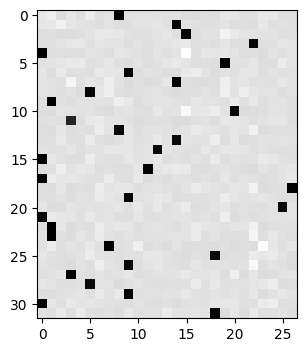

In [70]:
print(f"1st row of Softmax: {F.softmax(logits, dim=1)[0]}")
print(f"selected {Yb[0]}th element")
# Each row of dlogits sums to 0.
# Because d_cross_entropy = Softmax - one_hot, whereas the sum of softmax equals to 1, and sum of one_hot also equals to 1.
print(f"Sum of 1st row: {dlogits[0].sum() * MINI_BATCH_SIZE}")
# The one selected (10th) has the negative gradients, kind of pulling down the plane.
print(f"1st row: {dlogits[0] * MINI_BATCH_SIZE}")
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap="gray")

# Fast backprop for the BatchNorm

In [71]:
"""
bn_mean = (1/MINI_BATCH_SIZE) * linear.sum(dim=0, keepdim=True)
bn_diff = linear - bn_mean
bn_diff_square = bn_diff ** 2
bn_var = (1/(MINI_BATCH_SIZE-1)) * bn_diff_square.sum(dim=0, keepdim=True)
bn_var_inv = (bn_var + 1e-5) ** -0.5
bn_raw = bn_diff * bn_var_inv
bn_scaled = bngain * bn_raw + bnbias
"""
bn_scaled_fast = (
    bngain * (linear - linear.mean(0, keepdim=True)) / (linear.var(0, keepdim=True, unbiased=True) + 1e-5) ** -0.5
    + bnbias
)
print("max diff:", (bn_scaled_fast - bn_scaled).abs().max())

# Backprop
dlinear = (
    bngain
    * bn_var_inv
    / MINI_BATCH_SIZE
    * (
        MINI_BATCH_SIZE * dbn_scaled
        - dbn_scaled.sum(0)
        - MINI_BATCH_SIZE / (MINI_BATCH_SIZE - 1) * bn_raw * (dbn_scaled * bn_raw).sum(0)
    )
)

cmp("dlinear", dlinear, linear)  # I can only get approximate to be true, my maxdiff is 9e-10

max diff: tensor(8.9874, grad_fn=<MaxBackward1>)
dlinear | Exact: False | Approximate: True  | MaxDiff: 9.313225746154785e-10


# All in together

In [72]:
# Constants
ALPHABET_SPACE = len(stoi)
NGRAM_SIZE = 3
REPRESENTATION_DIM = 10
HIDDEN_LAYER_DIM = 64
MINI_BATCH_SIZE = 32

# Initialization
g = torch.Generator().manual_seed(2147483647)
C = torch.randn([ALPHABET_SPACE, REPRESENTATION_DIM], generator=g)  # (27, 10)
# Layer 1
W1 = (
    torch.randn([NGRAM_SIZE * REPRESENTATION_DIM, HIDDEN_LAYER_DIM], generator=g)
    * (5 / 3)
    / ((NGRAM_SIZE * REPRESENTATION_DIM) ** 0.5)
)  # (30, 64)
b1 = torch.randn([HIDDEN_LAYER_DIM], generator=g) * 0.1  # (64,)
# Layer 2
W2 = torch.randn([HIDDEN_LAYER_DIM, ALPHABET_SPACE], generator=g) * 0.1  # (64, 27)
b2 = torch.randn([ALPHABET_SPACE], generator=g) * 0.1  # (27,)
# BatchNorm Layer
bngain = torch.randn([1, HIDDEN_LAYER_DIM]) * 0.1 + 1.0  # (64,)
bnbias = torch.randn([1, HIDDEN_LAYER_DIM]) * 0.1  # (64,)

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

#
max_steps = 200000
lossi = []

with torch.no_grad():
    for i in range(max_steps):
        # mini batch
        ix = torch.randint(0, Xtr.shape[0], (MINI_BATCH_SIZE,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]

        # forward
        emb = C[Xb]
        emb_concat = emb.view(Xb.shape[0], -1)

        linear = emb_concat @ W1 + b1

        bn_mean = linear.mean(dim=0, keepdim=True)
        bn_var = linear.var(dim=0, unbiased=True, keepdim=True)
        bn_var_inv = (bn_var + 1e-5) ** -0.5
        bn_raw = (linear - bn_mean) * bn_var_inv
        bn_scaled = bngain * bn_raw + bnbias

        hidden = torch.tanh(bn_scaled)

        logits = hidden @ W2 + b2
        loss = F.cross_entropy(logits, Yb)

        # Backprop
        for p in parameters:
            p.grad = None

        # PyTorch backprop
        # loss.backward()

        # Manual backprop
        dlogits = F.softmax(logits, dim=1)
        dlogits[range(MINI_BATCH_SIZE), Yb] -= 1
        dlogits /= MINI_BATCH_SIZE

        dhidden = dlogits @ W2.T
        dW2 = hidden.T @ dlogits
        db2 = dlogits.sum(dim=0, keepdim=False)

        dbn_scaled = (1.0 - hidden**2) * dhidden

        dbngain = (bn_raw * dbn_scaled).sum(dim=0, keepdim=True)
        dbnbias = dbn_scaled.sum(dim=0, keepdim=True)
        dlinear = (
            bngain
            * bn_var_inv
            / MINI_BATCH_SIZE
            * (
                MINI_BATCH_SIZE * dbn_scaled
                - dbn_scaled.sum(0)
                - MINI_BATCH_SIZE / (MINI_BATCH_SIZE - 1) * bn_raw * (dbn_scaled * bn_raw).sum(0)
            )
        )

        demb_concat = dlinear @ W1.T
        dW1 = emb_concat.T @ dlinear
        db1 = dlinear.sum(dim=0, keepdim=False)

        demb = demb_concat.view(emb.shape)

        dC = torch.zeros_like(C)
        for row in range(Xb.shape[0]):
            for col in range(Xb.shape[1]):
                ix = Xb[row][col]
                dC[ix] += demb[row][col]

        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

        # Optimize
        lr = 0.1 if i < 100_000 else 0.01
        for p, grad in zip(parameters, grads):
            # p.data += lr * p.grad # PyTorch
            p.data += -lr * grad

        if i % 10_000 == 0:
            print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
        lossi.append(loss.log10().item())

4137
      0/ 200000: 3.3378
  10000/ 200000: 2.4359
  20000/ 200000: 2.1127
  30000/ 200000: 2.3243
  40000/ 200000: 2.2405
  50000/ 200000: 2.1444
  60000/ 200000: 2.1594
  70000/ 200000: 2.3827
  80000/ 200000: 2.1310
  90000/ 200000: 2.5554
 100000/ 200000: 2.1805
 110000/ 200000: 1.8397
 120000/ 200000: 2.0938
 130000/ 200000: 2.5371
 140000/ 200000: 1.8366
 150000/ 200000: 2.1594
 160000/ 200000: 2.0352
 170000/ 200000: 2.1917
 180000/ 200000: 1.9685
 190000/ 200000: 1.9738


In [73]:
# Calibrate after training
with torch.no_grad():
    emb = C[Xtr]
    emb_concat = emb.view(Xtr.shape[0], -1)
    linear = emb_concat @ W1 + b1
    bn_mean = linear.mean(dim=0, keepdim=True)
    bn_var = linear.var(dim=0, keepdim=True, unbiased=True)

In [74]:
# Evaluation


@torch.no_grad()
def split_loss(split: str):
    x, y = {"train": (Xtr, Ytr), "val": (Xval, Yval), "test": (Xtest, Ytest)}[split]
    emb = C[x]
    emb_concat = emb.view(x.shape[0], -1)
    linear = emb_concat @ W1 + b1
    bn_scaled = bngain * (linear - bn_mean) * (bn_var + 1e-5) ** -0.5 + bnbias
    hidden = torch.tanh(bn_scaled)
    logits = hidden @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.1463329792022705
val 2.162074565887451


In [75]:
# Sample
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    outs = []
    context = [0] * NGRAM_SIZE

    while True:
        # Forward pass:
        # Embedding:
        emb = C[torch.tensor([context])]
        emb_concat = emb.view(emb.shape[0], -1)
        linear = emb_concat @ W1 + b1
        bn_scaled = bngain * (linear - bn_mean) * (bn_var + 1e-5) ** -0.5 + bnbias
        hidden = torch.tanh(bn_scaled)
        logits = hidden @ W2 + b2

        # Sampling
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        outs.append(ix)
        if ix == 0:
            break

    print("".join(itos[i] for i in outs))

carlah.
amelle.
khi.
mrixhelty.
salaysie.
rahnen.
den.
rha.
kaeli.
nellaiah.
maiivon.
leigh.
ham.
joce.
quinn.
shon.
marianni.
wanthoniearisi.
jacee.
durli.
